<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> RED NEURONAL + PCA + UNDERSAMPLING </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [6]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para normalizar los resultados
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import make_pipeline

# Paquetes para aplicar el modelo: Red neuronal
from sklearn.model_selection import GridSearchCV           # grid de parámetros definido
from sklearn.model_selection import RandomizedSearchCV     # grid de parámetros aleatorios sobre una determinada
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Importar DataSets
Importamos los datasets Train-Test y Evaluación para los que se ha aplicado PCA y submuestreo para ajustar la distribución de la clase mayoritaria.

In [7]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## TrainTest

In [8]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_under_pca.csv',Filename = '/tmp/train_test_under_pca.csv')

In [9]:
#Leemos el fichero y lo metemos en un dataframe.
trainTestPca = pd.read_csv('/tmp/train_test_under_pca.csv', dtype={'rank':'category'})

In [10]:
print (trainTestPca.shape)

(74130, 5)


In [11]:
trainTestPca.head()

,PC0,PC1,PC2,PC3,isFraud
0,-2.568416e+06,-418753.356792,-26107.093843,36123.614588,1.0
1,-2.556271e+06,-435297.382974,-7558.987926,28869.723793,1.0
2,-2.568229e+06,-415170.264690,-23825.616824,34557.111152,1.0
3,-2.553205e+06,-435635.120416,-881.727142,25584.094128,1.0
4,-2.566995e+06,-391525.951775,-8770.475899,24219.978765,1.0


In [12]:
pd.value_counts(trainTestPca['isFraud'])

0.0    66717
1.0     7413
Name: isFraud, dtype: int64

In [13]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_under_pca.csv

## Evaluacion

In [14]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_under_pca.csv',Filename = '/tmp/eval_under_pca.csv')

In [15]:
#Leemos el fichero y lo metemos en un dataframe.
evalPca = pd.read_csv('/tmp/eval_under_pca.csv', dtype={'rank':'category'})

In [16]:
print (evalPca.shape)

(80000, 5)


In [17]:
evalPca.head()

,PC0,PC1,PC2,PC3,isFraud
0,-2.440498e+06,2.032612e+06,1.534761e+06,-1.035596e+06,1.0
1,-1.555564e+06,-3.347021e+05,5.046703e+04,6.319293e+03,1.0
2,-2.550707e+06,-7.939223e+04,1.899757e+05,-1.122428e+05,1.0
3,-8.871237e+05,2.460477e+06,1.405758e+05,-3.504298e+05,1.0
4,-2.558167e+06,-2.223525e+05,9.894805e+04,-4.974151e+04,1.0


In [18]:
pd.value_counts(evalPca['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [19]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_under_pca.csv

## Red de Neuronas
En este caso, para aplicar una red neuronal, vamos a normalizar los datos para mejorar los resultados:

### Entrenamiento y test del modelo

In [20]:
## Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
y = trainTestPca.loc[:, 'isFraud'].values
X = trainTestPca.drop(columns=['isFraud']).values

In [21]:
# Creamos los conjuntos de entrenamiento y test:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Verificamos los tamaños de los df:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51891, 4), (22239, 4), (51891,), (22239,))

En una red neuronal, la Función de Activación de un nodo define la salida de un nodo dada una entrada o un conjunto de entradas. Hemos probado las funciones de activación 'relu' y 'logistic' y para este caso, mediante la función de activación logistica obtenemos mejores resultados:

In [22]:
# Configuramos una red de neuronas
norm =StandardScaler()
mlp=MLPClassifier(activation = 'logistic', 
                  solver='adam', 
                  alpha=1e-5,
                  max_iter=500,
                  hidden_layer_sizes=(3, 1), 
                  random_state=1, 
                  verbose=True,
                 early_stopping =True)
mlpUnderPca=make_pipeline(norm, mlp)

In [23]:
# Ajustar el modelo
mlpUnderPca.fit(X_train, y_train)

Iteration 1, loss = 0.75584163
Validation score: 0.912139
Iteration 2, loss = 0.57013521
Validation score: 0.900000
Iteration 3, loss = 0.44159830
Validation score: 0.900000
Iteration 4, loss = 0.37277594
Validation score: 0.900000
Iteration 5, loss = 0.33709318
Validation score: 0.900000
Iteration 6, loss = 0.31747431
Validation score: 0.900000
Iteration 7, loss = 0.30563605
Validation score: 0.900000
Iteration 8, loss = 0.29743016
Validation score: 0.900000
Iteration 9, loss = 0.29058542
Validation score: 0.900000
Iteration 10, loss = 0.28391236
Validation score: 0.900000
Iteration 11, loss = 0.27689898
Validation score: 0.900000
Iteration 12, loss = 0.26935583
Validation score: 0.900000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='logistic', alpha=1e-05,
                               early_stopping=True, hidden_layer_sizes=(3, 1),
                               max_iter=500, random_state=1, verbose=True))])

In [24]:
# Realizamos la predicción sobre el conjunto de test
mlpUnderPca_pred=mlpUnderPca.predict(X_test)

print(classification_report(y_test, mlpUnderPca_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, mlpUnderPca_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     20012
         1.0       1.00      0.12      0.21      2227

    accuracy                           0.91     22239
   macro avg       0.96      0.56      0.58     22239
weighted avg       0.92      0.91      0.88     22239

                 Precicted No Default  Predicted Default
True No Default                 20012                  0
True Default                     1970                257


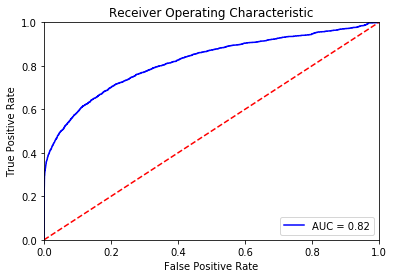

In [25]:
# Área bajo la curva ROC:  
    # Para calcular el área bajo la curva ROC (AUC) es necesario obtener
    # la probabilidad de salida del clasificador con `predict_proba`
prediccion_prob = mlpUnderPca.predict_proba(X_test)
#la primera columna corresponde a la etiqueta 'N'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta N)
roc_auc_score((y_test==0), prediccion_prob[:,0])

probs = mlpUnderPca.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Clasificación de nuevos valores 
Aplicamos el modelo al dataframe de evaluación:

In [26]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
evaly = evalPca.loc[:, 'isFraud'].values
evalX = evalPca.drop(columns=['isFraud']).values

In [27]:
# Aplicamos el modelo
mlpUnderPca.score(evalX, evaly)

0.9914

In [28]:
# Calculamos la predicción
predEval = mlpUnderPca.predict(evalX)

In [29]:
# Matriz de confusión
cm=confusion_matrix(evaly, predEval)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,79200,0
1_true,688,112


In [30]:
pru = np.where(predEval > 0.4,1,0)
print(classification_report(evaly, pru))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     79200
         1.0       1.00      0.14      0.25       800

    accuracy                           0.99     80000
   macro avg       1.00      0.57      0.62     80000
weighted avg       0.99      0.99      0.99     80000



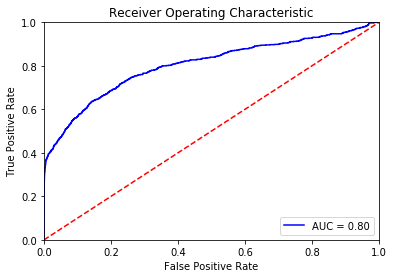

In [31]:
# Curva ROC
probs_eval = mlpUnderPca.predict_proba(evalX)
preds_eval = probs_eval[:,1]
fpr_eval, tpr_eval, threshold_eval = metrics.roc_curve(evaly, preds_eval)
roc_auc_eval = metrics.auc(fpr_eval, tpr_eval)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_eval, tpr_eval, 'b', label = 'AUC = %0.2f' % roc_auc_eval)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Guardamos la predicción
Guardamos la predicción realizada en el dataframe de Evaluación:

In [18]:
predNN = pd.DataFrame(predEval, columns = ["NNUnderPCA_pred"])
modelResult = pd.concat([evalPca, predNN["NNUnderPCA_pred"]],axis = 1)
modelResult.head()

,PC0,PC1,PC2,PC3,isFraud,NNUnderPCA_pred
0,-2.100031e+06,4.656290e+05,20430.461566,-9.374458e+04,1.0,0.0
1,2.429940e+06,1.029284e+07,599933.978468,-1.412732e+06,1.0,1.0
2,-2.071870e+06,6.522836e+05,35366.030956,-1.175537e+05,1.0,0.0
3,-2.549971e+06,-2.140229e+05,-132302.820399,-6.358643e+04,1.0,0.0
4,-2.545410e+06,-1.153373e+05,-179789.156408,-1.053899e+05,1.0,0.0


In [19]:
pd.crosstab(index=modelResult['isFraud'],columns=modelResult['NNUnderPCA_pred'], margins=True)

NNUnderPCA_pred,0.0,1.0,All
isFraud,,,
0.0,79066,134,79200
1.0,711,89,800
All,79777,223,80000
